# 1부. 목적에 따른 시각화 방법 정리


## I. 모델이 어떤 피처를 중요하게 보는지
---

### 1. Feature Importance 시각화

모델이 어떤 피처를 중요하게 생각하는지를 수치화하여 시각적으로 표현 

- Feature Importance 분류 및 작동방식 :
    - **전역적 피처 중요도(Global Feature Importance)**
        - 모델 전체에 대해 각 피처의 중요도를 분석
        - Built-in Importance
            - tree 기반 모델
                - 노드 불순도 감소 기반으로 중요도 계산 
                - `sklearn.feature_importances_`, ❌`xgboost.get_booster().get_score()`
            - linear 모델
                - 계수의 절대값 크기 기반으로 중요도 계산
        - Permutation Importance
            - 각 피처의 값을 무작위로 섞어 모델 성능 저하 계산(중요한 특성일수록 섞었을 때 성능 저하가 큰 것에서 착안)
            - `sklearn.inspection.permutation_importance`
        - SHapley Additive exPlanations (SHAP) Values
            - Shapley 값을 기반, 가능한 모든 피처 조합을 고려하여 기여도를 계산
            - SHAP의 `shap.Explainer(model, X)` + `shap.summary_plot()`: SHAP 괎을 활용, 전반적인 예측에 대한 각 피처의 기여도 계산
        - ⭐ [ELI5](https://github.com/eli5-org/eli5) 패키지
    - **국소적 피처 중요도(Local Feature Importance)**
        - 개별 데이터 포인트 예측에 대한 피처 기여도를 분석
        - SHAP의 `shap.force_plot()`: SHAP 값 활용, 개별 예측에 대한 각 피처의 기여도 계산
        - LIME의 `explain_instance()`: 특정 예측을 지역적으로 해석 가능한 모델(선형모델)을 학습시켜 근사 후 이 지역 모델의 계수를 통해 특성 중요도 도출

- **SHAP, ELI5, InterpretML, Captum** 등 다양한 라이브러리 사용 가능

- 관련 논문: 
    - [Breiman, L. (2001). *Random Forests*. Machine Learning.](https://link.springer.com/article/10.1023/A:1010933404324)
        - 랜덤 포레스트에서 피처 중요도를 평가하는 방법(*퍼뮤테이션 중요도* 등)을 제안: 'Internal estimates are also used to measure variable importance.'
    - [Fisher, A., Rudin, C., & Dominici, F. (2019). *All Models are Wrong, but Many are Useful: Variable Importance for Black-Box, Proprietary, or Misspecified Prediction Models*.](https://arxiv.org/abs/1801.01489)
        - 모델 클래스 의존성(Model Class Reliance, MCR)이라는 개념을 도입, 블랙박스 모델에서 피처 중요도를 평가하는 다양한 방법 제안

### 2. Feature Importance 시각화 예시

##### `sklearn` 기반 모델의 matplotlib을 이용한 간단한 시각화

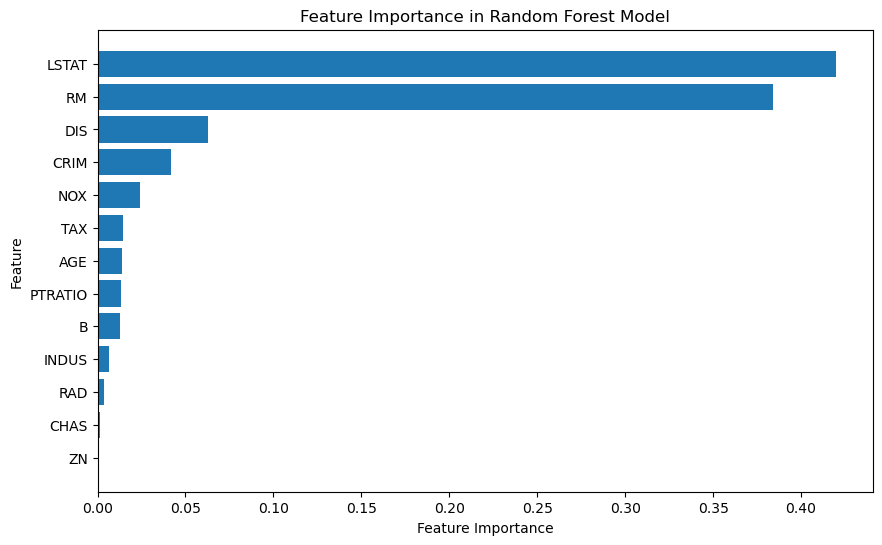

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Data loading
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

# train-test split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=617)

# RF model training
model = RandomForestRegressor(n_estimators=100, random_state=617)
model.fit(X_train, y_train)

# Feature importance extraction
feature_importances = model.feature_importances_

# Plotting feature importance
sorted_idx = np.argsort(feature_importances) # in descending order by importance 
sorted_features = np.array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT'])[sorted_idx]
sorted_importances = feature_importances[sorted_idx]

plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest Model')
plt.show()


##### `sklearn.inspection.permutation_importance`

C:\Users\djroz\AppData\Local\Temp\ipykernel_1672\1001894994.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(result.importances[sorted_idx].T,


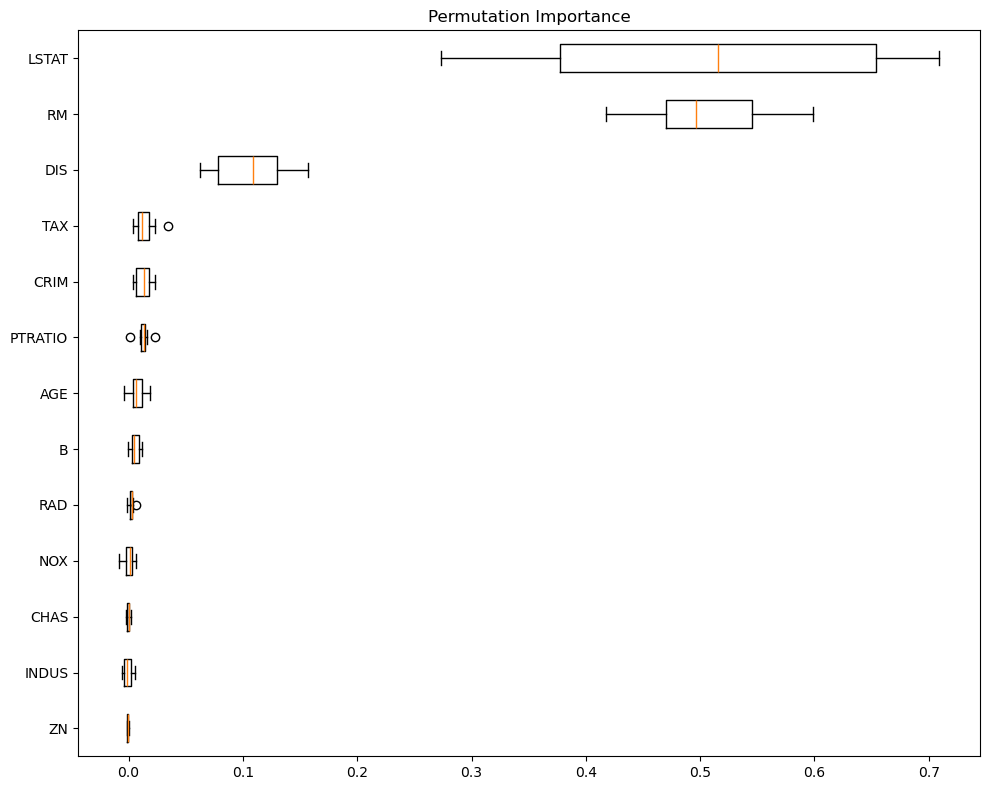

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_breast_cancer

# Data loading
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

# train-test split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=617)

# RF model training
model = RandomForestRegressor(n_estimators=100, random_state=617)
model.fit(X_train, y_train)

# Calculating Permutation importance
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=617)

# Plotting  importance
sorted_idx = result.importances_mean.argsort() # in descending order by importance 
feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

plt.figure(figsize=(10, 8))
plt.boxplot(result.importances[sorted_idx].T, 
            vert=False, 
            labels=np.array(feature_names)[sorted_idx])  
plt.title("Permutation Importance")
plt.tight_layout()
plt.show()

##### `shap.summary_plot()`

c:\Users\djroz\anaconda3\envs\py3_10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


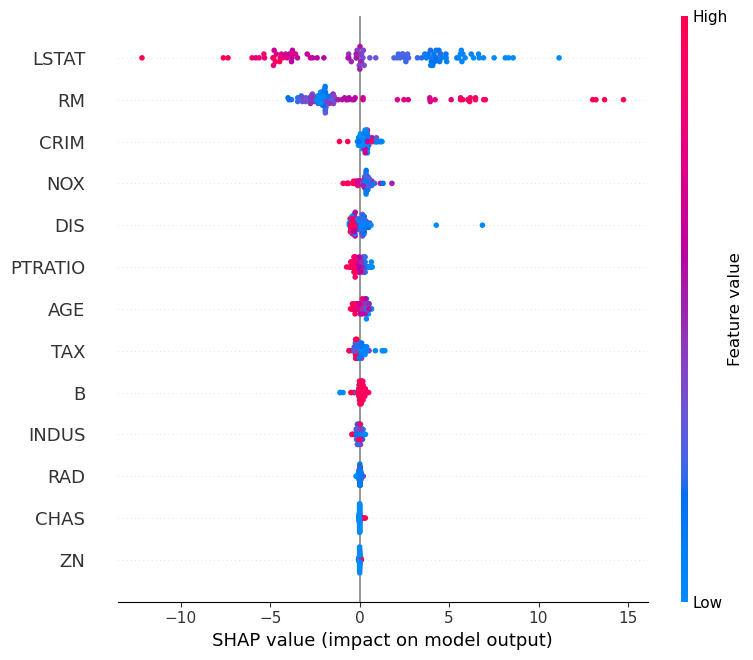

In [3]:
import pandas as pd
import numpy as np
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Data loading
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

# train-test split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=617)

# RF model training
model = RandomForestRegressor(n_estimators=100, random_state=617)
model.fit(X_train, y_train)

# TreeExplainer for generating SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Plotting SHAP summary plot 
shap.summary_plot(shap_values, X_test, feature_names=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT'])
plt.show()

##### `shap.force_plot()`

In [4]:
import pandas as pd
import numpy as np
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Data loading
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

# train-test split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=617)

# RF model training
model = RandomForestRegressor(n_estimators=100, random_state=617)
model.fit(X_train, y_train)

# TreeExplainer for generating SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Plotting SHAP force plot
data_point = X_test[0]  # Example data point to explain
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], data_point, feature_names=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT'])


##### LIME의 `explain_instance()` 

In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import lime
import lime.lime_tabular

# Data loading
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

# train-test split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=617)

# RF model training
model = RandomForestRegressor(n_estimators=100, random_state=617)
model.fit(X_train, y_train)

# LIME Explainer 
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT'], class_names=['price'], verbose=True, mode='regression')

# Generating explanation for a specific data point
i = 0  # first one!
exp = explainer.explain_instance(X_test[i], model.predict, num_features=5)

# Plotting the explanation
exp.show_in_notebook(show_table=True, show_all=False)

Intercept 25.730294557082775
Prediction_local [16.40694851]
Right: 17.383


##### Captum의 `captum.attr.IntegratedGradients()`

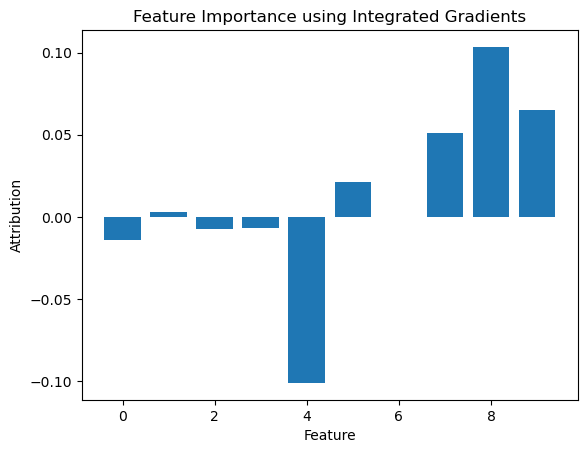

In [6]:
import torch
import torch.nn as nn
import captum
from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt

# Simple neural network model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(10, 10)
        self.fc2 = nn.Linear(10, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleNN()
model.eval()

# Sampe data
X = torch.rand(1, 10)

# Calculating feature importance using Integrated Gradients
ig = IntegratedGradients(model)
attributions, delta = ig.attribute(X, target=0, return_convergence_delta=True)

# Plotting the feature importance
plt.bar(range(10), attributions.detach().numpy()[0])
plt.xlabel('Feature')
plt.ylabel('Attribution')
plt.title('Feature Importance using Integrated Gradients')
plt.show()


## II. 특정 피처가 예측값에 미치는 영향
--- 

입력 데이터가 모델에 미치는 영향을 분석


### 1. **특정 피처값 변화에 따른 예측값 변화를 시각화** : Partial Dependence Plot (PDP)

특정 피처의 값이 변할 때 모델의 예측값이 어떻게 변하는지 시각적으로 표현  
선택한 특정 피처 값에 따라 어떻게 변화(반응)하는지 분석하여 해석 가능성을 높일 수 있음   

- 작동 방식:
    - 특정 변수의 모든 샘플을 특정 값으로 대체하고, 이미 학습시킨 모델을 통해 각 샘플에 대한 예측값을 구함
        - 관심있는 특정 피처가 A일때, A의 가능한 여러 값들에 대해 모델의 예측값을 계산
        - 이때 다른 모든 피처(B, C, ...)들을 고정하지 않고 평균화(marginalizing)하여 계산 후 예측값을 시각화

- 주의점:
    - 개별 데이터 포인트가 무시됨: 개별 데이터 포인트에서 관찰될 수 있는 예측값의 변화는 확인이 어려움
    - 비선형성, 복잡성 등에 제한적: 평균적인 영향을 단순화시켜 시각화하므로 데이터의 특정 영역에서 예상치 못한 방식으로 모델이 동작할 경우 이러한 세부사항을 표현하기 어려움 (데이터포인트가 없는 부분에 기대 곡선이 표현되는 것을 외삽 extrapolation이라고 함)

|image| --- |
| --- | --- |
| 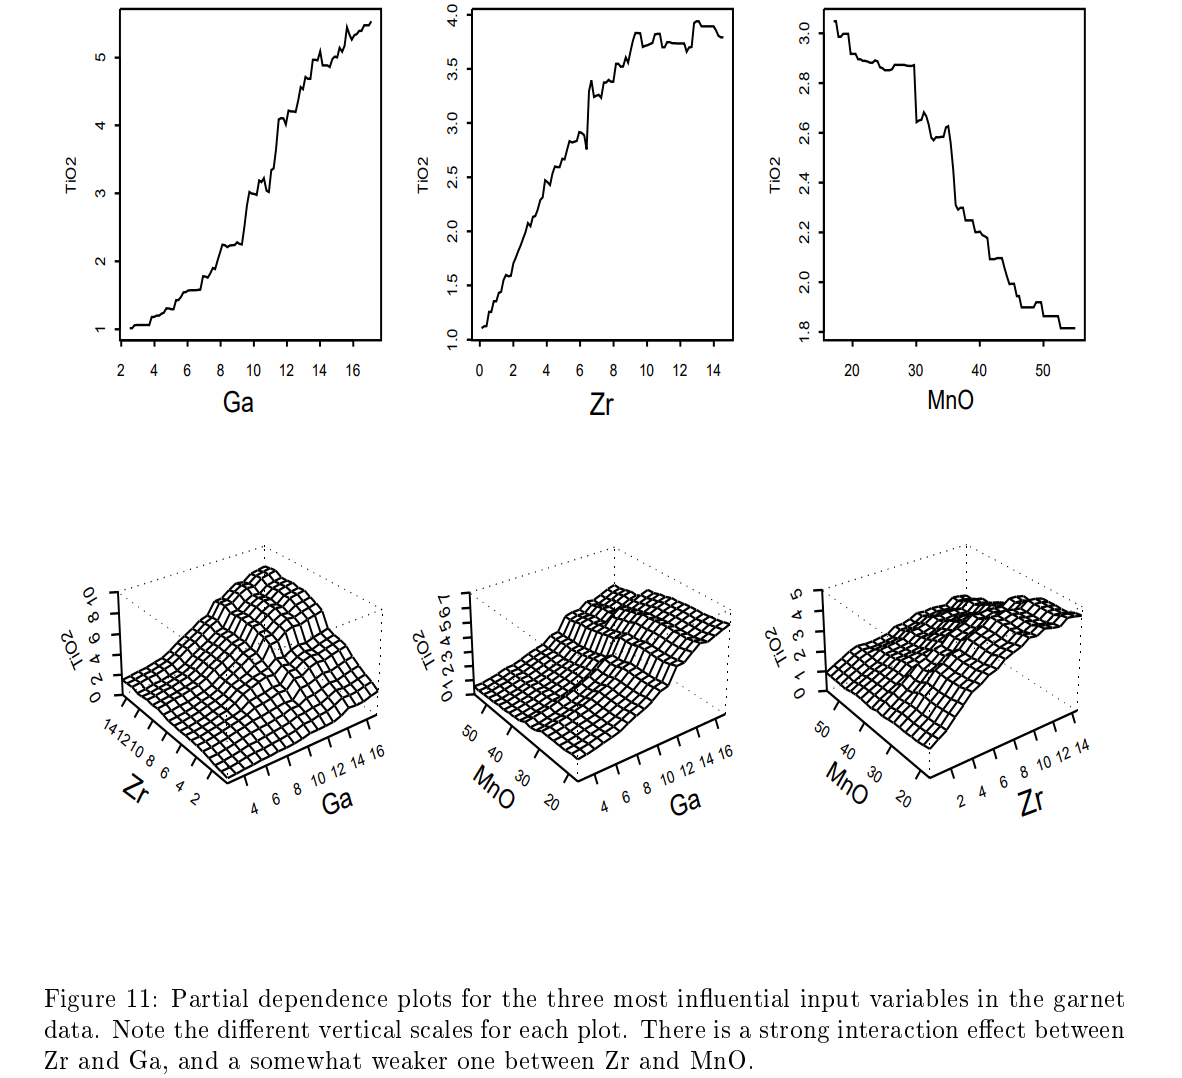 | ex1 |
|"3개의 주 영향력있는 변수들에 대한 PDP. Zr과 Ga 사이에 강한 교호작용이 보이며 Zr와  MnO는 그래보이지 않는다." (reference: *Greedy Function Approximation: A Gradient Boosting Machine* p.34) | ex | im |

</br>  

- **InterpretML**, **SHAP**, **Scikit-learn** 등 사용 가능

- [Scikit-learn](https://scikit-learn.org/stable/auto_examples/inspection/plot_partial_dependence.html): `sklearn.inspection.plot_partial_dependence()`
    - 1D PDP: 단일 피처의 변화에 따른 예측값 변화를 선 그래프로 표현
    - 2D PDP: 두 개의 피처가 동시에 변화할 때의 영향 분석(등고선 형태), 예측값의 크기는 색상의 차이로 표현됨 (2개의 피처로 3D도 가능)
        - `sklearn.inspection.plot_partial_dependence()`에 `features = [('feature_1', 'feature_2')]` 튜플 형태로 넣어줌  

- [PDPbox](https://github.com/SauceCat/PDPbox) : PDP 그래프에 최적화된 패키지  
- ❌ [`shap.DeepExplainer`](https://shap.readthedocs.io/en/latest/generated/shap.DeepExplainer.html): 
    - shap값으로 그릴 수 있는지 확실한지.... 


- 관련 논문:
    - [Friedman, J. H. (2001). *Greedy Function Approximation: A Gradient Boosting Machine*. *Annals of statistics, 29(5), 1189-1232.*](https://jerryfriedman.su.domains/ftp/trebst.pdf)
        - XGBoost 등장 논문, 8.2절에서 피처의 변화가 예측값에 미치는 영향을 설명
    - [Greenwell, B. M. (2017). *pdp: An R Package for Constructing Partial Dependence Plots*.](https://journal.r-project.org/archive/2017/RJ-2017-016/RJ-2017-016.pdf)
        - PDP를 쉽게 구현할 수 있는 R 패키지를 소개하고 실제 분석 사례를 포함

#### PDP 시각화 예시

##### PDP 1D code example

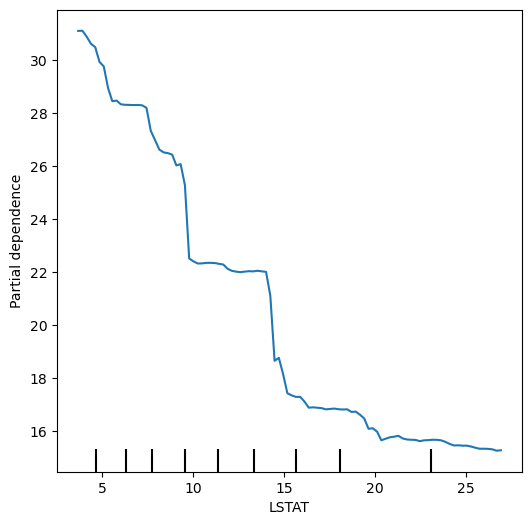

In [9]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

# Data loading
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

# Create a DataFrame with the data
columns = ["CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT"]
df = pd.DataFrame(data, columns=columns)
df['MEDV'] = target

# train-test split
X_train, X_test, y_train, y_test = train_test_split(df[columns], df['MEDV'], test_size=0.2, random_state=617)

# RF model training
model = RandomForestRegressor(n_estimators=100, random_state=617)
model.fit(X_train, y_train)

# PDP for LSTAT
fig, ax = plt.subplots(figsize=(6, 6))
display = PartialDependenceDisplay.from_estimator(estimator=model, X=df[columns], features=['LSTAT'], ax=ax)
plt.show()

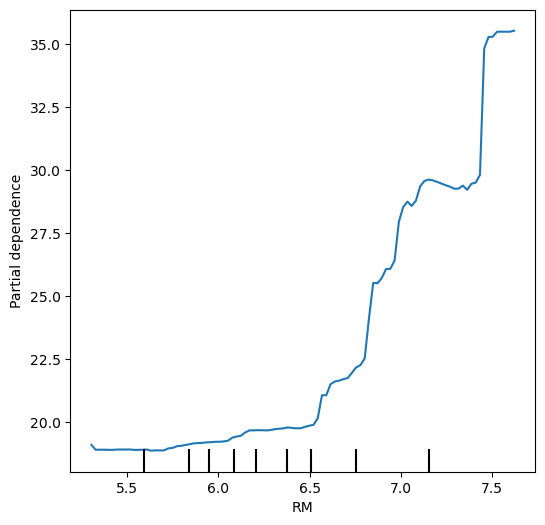

In [10]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

# Data loading
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

# Create a DataFrame with the data
columns = ["CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT"]
df = pd.DataFrame(data, columns=columns)
df['MEDV'] = target

# train-test split
X_train, X_test, y_train, y_test = train_test_split(df[columns], df['MEDV'], test_size=0.2, random_state=617)

# RF model training
model = RandomForestRegressor(n_estimators=100, random_state=617)
model.fit(X_train, y_train)

# PDP for LSTAT
fig, ax = plt.subplots(figsize=(6, 6))
display = PartialDependenceDisplay.from_estimator(estimator=model, X=df[columns], features=['RM'], ax=ax)
plt.show()

##### PDP 2D code example

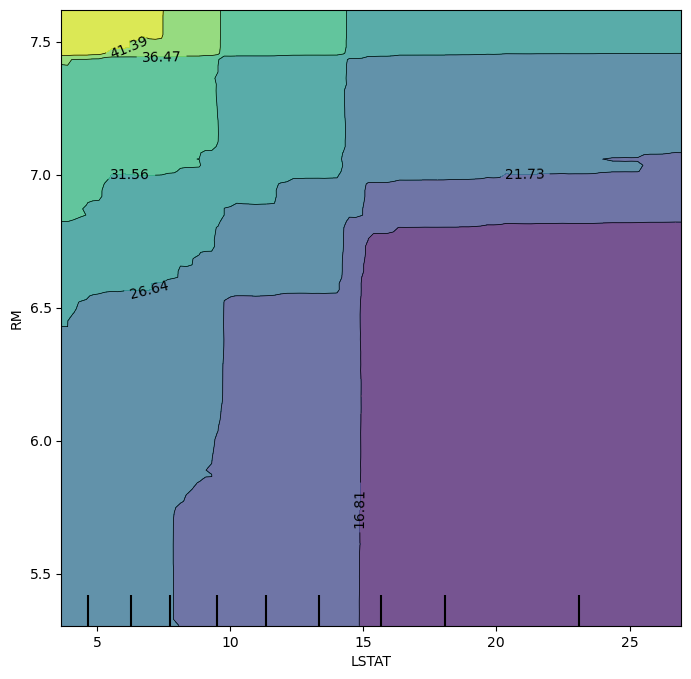

In [11]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

# Data loading
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

# Create a DataFrame with the data
columns = ["CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT"]
df = pd.DataFrame(data, columns=columns)
df['MEDV'] = target

# train-test split
X_train, X_test, y_train, y_test = train_test_split(df[columns], df['MEDV'], test_size=0.2, random_state=617)

# RF model training
model = RandomForestRegressor(n_estimators=100, random_state=617)
model.fit(X_train, y_train)

# PDP for LSTAT and RM
fig, ax = plt.subplots(figsize=(8, 8))
display = PartialDependenceDisplay.from_estimator(estimator=model, X=df[columns], features=[('LSTAT', 'RM')], ax=ax)
plt.show()


### 💜 2. **피처 변화에 따른 개별 데이터 포인트의 예측 변화를 시각화** : Individual Conditional Expectation (ICE) Plot

~~ PDP와 유사하지만 개별 데이터 샘플별 변화를 보여줌~~ 

 PDP의 보완적인인 형태로, 관심있는 피처의 값 변화에 따른 개별 데이터 포인트의 예측값 변화를 시각적으로 표현  
    (PDP는 모든 샘플에 대한 평균적인 영향을 보여준다면 ICE plot은 개별 데이터 포인트에 대한 영향을 모두 시각화)

- 작동 방식: 
    - ICE plot은 모든 샘플을 선으로 그리는 것으로 전체 n개 샘플만큼 n개의 선이 그려짐짐

- 주의점
    - 샘플 수가 많거나 변수의 cardinality가 클 수록 연산량 급격히 증가: 샘플 수가 많으면 샘플링 한 뒤 시각화 하는 것이 좋음음
    - 변수 간의 상관성이 높을 때 비정상적인 시각화가 생성될 수 있음

~~ 💁‍♀️ PDP는 선형회귀에서 어떤 변수에 대한 회귀계수를 기울기로 하여 그래프를 그려보면 해당 변수와 target이 양의 선형관계인지 음의 선형관계인지 확인이 가능하게 된다.
ICE plot은 모든 선을 그려버리는 것으로 전체 n개 샘플만큼 n개의 선을 그리므로 PDP에서 확인하기 어려웠던 feature간의 교호작용을 확인할 수 있다.
예시가 너무 정갈하고 해석하기 좋은 예시인데요. (https://dodonam.tistory.com/373) PDP만 보면 교호작용을 파악할수 없었으나 ICE로 파악이 가능해진다.  ~~




|image| --- |
| --- | --- |
| 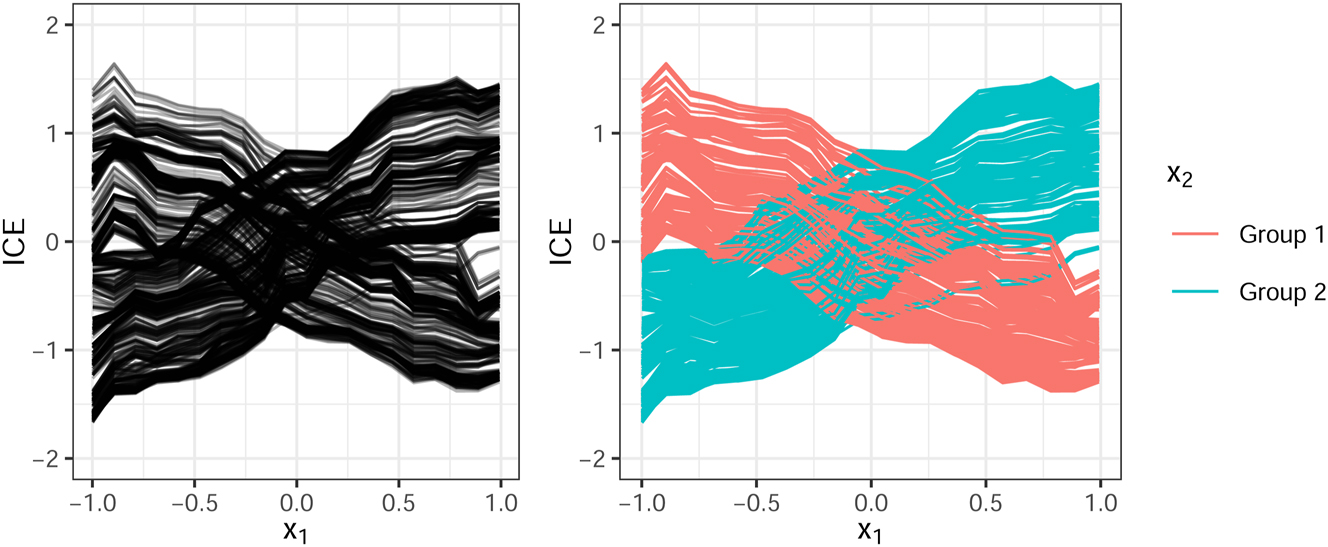 | ex1 |
|그림2: 같은 ICE 그래프에서 색상으로 다른 피처를 구분했을때 (reference: *Detecting interactions with random forests: a comment on Gries’ words*)  | ex | im |



- 적용 가능 라이브러리:   
- 개별 데이터 포인트마다 별도의 선으로 표현되므로 피처가 변함에 따라 특정 데이터 포인트가 어떻게 반응하는지 추적할 수 있음



- 각 라인이 하나의 데이터 포인트를 나타냄
- 라인들이 서로 평행하지 않고 교차하거나 다른 방향으로 움직이면 이는 해당 피처가 다른 피처들과 상호작용함을 의미함

- [Scikit-learn](https://scikit-learn.org/stable/auto_examples/inspection/plot_partial_dependence.html) : 
    - `sklearn.inspection.partial_dependence()`의 옵션에 `kind='individual'`.   
      (`'both'`로 설정하면 PDP도 그려주지만 같은 색상으로 표시됨. `'average'`로 옵션을 주면 원래의 PDP 값을 시각화 가능)
- [interpret]() 패키지:  



     
- 관련 논문:
    - PDP 2번째 논문  
    - [Strobl, Carolin; Rothacher, Yannick; Theiler, Sven; Henninger, Mirka (2024). *Detecting interactions with random forests: a comment on Gries’ words*](https://www.degruyterbrill.com/document/doi/10.1515/cllt-2024-0028/html)
        - ICE 플롯이 interaction 효과를 감지하는데 도움이 되는 것에 대해 설명
    -  [*Deep learning speeds up ice flow modelling by several orders of magnitude*]()

#### ICE plot 시각화 예시

### 3. **특정 피처값이 변할 때 피처의 기여도(SHAP)의 변화를 시각화** : SHAP Dependence Plot 

특정 피처의 값이 변할 때 SHAP 값(피처의 기여도)이 어떻게 변하는지를 분석  


- **SHAP Dependence Plot**
    - SHAP값을 활용하여 특정 피처를 바꾸면서 피처와 예측값 간의 상관관계를 시각화

- 관련 논문: [Friedman, J. H. (2001). *Greedy Function Approximation: A Gradient Boosting Machine*. *Annals of statistics, 29(5), 1189-1232.*](https://jerryfriedman.su.domains/ftp/trebst.pdf) (PDP의 개념이 처음 등장한 논문)



- 적용 가능 라이브러리: **SHAP**
- 해석 방식: 
    - X축: 피처 값, Y축: SHAP 값(모델 기여도)
    - 색상: 상관관계가 있는 다른 피처 (관계성 분석 가능)
- 관련 논문:
    - [Lundberg, S. M., & Lee, S.-I. (2017). *A Unified Approach to Interpreting Model Predictions*. NeurIPS.](https://arxiv.org/abs/1705.07874)
        - SHAP 값을 기반으로 피처 중요도를 계산하는 방법을 제안
    - [Covert, I., Lundberg, S. M., & Lee, S.-I. (2020). *Understanding Global Feature Contributions With Additive Importance Measures*. NeurIPS.](https://arxiv.org/abs/2004.00668)
        - SHAP을 활용하여 전역적 및 지역적 피처 기여도를 분석하는 방법을 다룸

#### SHAP Dependence 시각화 예시

## III. 특정 데이터 포인트를 추적하고 싶을 때
---

데이터 샘플별로 모델에 미친 중요도 분석 (샘플플 단위의 개별적인 예측 결과를 해석하고자 할 때)


### 2. **특정 데이터 포인트의 기여도 시각화** : LIME Explanation Visualization

개별 데이터 포인트에 대해 피처의 기여도를 시각적으로 표현 (로컬 해석)  

- 적용 가능 라이브러리: **LIME**  
- 막대그래프 형태로 각 피처가 예측값에 미치는 영향(긍정/부정) 표시  
- 관련 논문:
    - [Ribeiro, M. T., Singh, S., & Guestrin, C. (2016). *"Why Should I Trust You?" Explaining the Predictions of Any Classifier*. KDD.](https://arxiv.org/abs/1602.04938)  
        - LIME 기법을 제안하여 블랙박스 모델의 개별 예측을 해석하는 방법을 설명  
    - [Garreau, D., & Luxburg, U. V. (2020). *Explaining the Explainer: A First Theoretical Analysis of LIME*.](https://arxiv.org/abs/2001.03447)
        - LIME의 수학적 기반과 한계를 분석하여 신뢰성을 평가  


### 3. **개별 샘플에 대한 예측값 형성 과정 시각화** : SHAP Force Plot

개별 데이터 샘플에 대해 예측값이 형성되는 과정을 시각적으로 표현
- 적용 가능 라이브러리: **SHAP** (SHAP force plot)
- 기본값에서 출발해 각 피처가 어떻게 영향을 미쳐 최종 예측값이 나오는지를 보여줌
- 관련 논문:
    - [Lundberg, S. M., Erion, G., & Lee, S.-I. (2018). *Consistent Individualized Feature Attribution for Tree Ensembles*. ICML.](https://arxiv.org/abs/1802.03888)
        - SHAP 기반의 Force Plot을 포함하여여 개별 예측에 대한 해석 기법을 설명

##### **SHAP Waterfall Plot**


개별 예측의 기여도 이해하는 데 유용

## IV. 모델 내부 표현 시각화 
### 1. **모델이 학습한 공간을 시각화** : Embedding Space Visualization

모델이 데이터를 어떻게 내재화(embedding)했는지 즉 어떻게 이해해했는지 분석.  
학습한 특징(Feature)이 어떻게 분포하는지를 분석하는 데 중요.  

- 모델이 학습한 공간이 왜 중요할까?

    1. 모델이 어떻게 이해했는지 분석  
    비슷한 의미의 단어, 이미지, 데이터 포인트를 모델이 가까이 배치하였는지 확인할 수 있다.  
    (예: Word2Vec, BERT 임베딩에서 ‘king’과 ‘queen’이 가깝게 위치하는지 확인 가능)  

    2. 학습된 특징이 올바르게 분포하는지 검증  
    학습이 잘 되었는지 혹은 과적합(overfitting)되었는지 확인할 수 있다.  
    클래스 간의 경계가 잘 형성되었는지 시각적으로 판단할 수 있다.  

    3. 고차원 데이터를 직관적으로 이해  
    NLP에서는 단어 임베딩, CV에서는 이미지 특징 임베딩이 높은 차원의 벡터로 표현된다.  
    따라서 이를 저차원으로 줄여 시각화하면 데이터의 패턴을 더 쉽게 해석할 수 있다.  

    4. 클러스터링 및 이상 탐지(Anomaly Detection)  
    정상적인 데이터와 이상 데이터가 잘 구분되는지 확인할 수 있다.  
    따라서 이상값(Outlier) 탐지에 활용될 수도 있다.  


- 사람이 이해할 수 있도록 t-SNE, UMAP을 활용하여 모델이 학습한 공간(Feature Representationn)인고차원 벡터를 2D 또는 3D로 투영  
- `sklearn.manifold.TSNE`, `umap-learn` 등 사용  
- 직관적이지만 비선형 구조를 표현하는데 어려움이 있음  
- 관련 논문: [Maaten, L. V. D., & Hinton, G. (2008). "Visualizing data using t-SNE." *JMLR, 9(Nov), 2579-2605.*](https://www.jmlr.org/papers/v9/vandermaaten08a.html)

### 2. **모델의 의사결정 경로 추적**: Decision Tree Feature Importance, LRP

- **Decision Tree Feature Importance**
    - 트리 기반 모델(XGBoost, Random Forest 등)의 의사결정 과정 시각화
    - `tree.export_graphviz()`, `shap.TreeExplainer()`, `eli5.show_weights()`
- **Neural Network Feature Attribution (Layer-wise Relevance Propagation, LRP)**
    - 뉴럴 네트워크가 어떤 피처를 중요하게 여겼는지 역추적
    - `innvestigate` 패키지 활용
    - 관련 논문: [Bach, S., et al. (2015). "On pixel-wise explanations for non-linear classifier decisions by layer-wise relevance propagation." *PloS one, 10(7), e0130140.*](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0130140)

### 3. **데이터 샘플의 모델 내부 표현** : Activation Map, Attention Map 
모델이 특정 데이터를 어떻게 "이해"하고 있는지 확인하는 방법.

- **CNN 모델의 Activation Map (Feature Map)**
    - 특정 레이어에서 활성화된 뉴런이 원본 이미지의 어떤 영역을 활성화시키는지를 분석하는 기법
    - CNN 모델의의 중간 레이어의 활성화 값을 직접 출력하여 모델이 어떤 패턴을 감지하는지 확인 가능
    - `torchvision.utils.make_grid()`, `tensorflow.keras.models.Model` 활용 
    - 관련 논문: [Zeiler, M. D., & Fergus, R. (2014). "Visualizing and understanding convolutional networks." *ECCV.*](https://arxiv.org/abs/1706.03762)

- **Transformer 모델의 Attention Map**
    - BERT, GPT 등의 Transformer 모델이 특정 단어 간 관계를 어떻게 인식하는지 시각화
    - `bertviz`, `transformers` 활용해 Attention Map 시각화 가능
    - 관련 논문: [Vaswani, A., et al. (2017). "Attention is all you need." *NeurIPS.*](https://arxiv.org/abs/1311.2901)


## 💜 V. 예측 과정의 불확실성 시각화

### 1. **Bayesian Model Uncertainty** 

<!-- - **Confidence Interval (예측 신뢰구간 시각화)**
    - 모델이 얼마나 확신을 가지고 예측하는지 분석
    - `seaborn.regplot(confidence_interval=True)` -->
- **Bayesian Model Uncertainty**
    - 베이지안 추론을 이용해 불확실성을 시각화 (Dropout + Monte Carlo)
    - `tensorflow-probability`, `Pyro` 활용
    - 관련 논문: [Gal, Y., & Ghahramani, Z. (2016). "Dropout as a Bayesian approximation: Representing model uncertainty in deep learning." *ICML.*](https://arxiv.org/abs/1506.02142)

### 2. **Prediction Intervals**


### 3. **Confidence Calibration**